In this notebook, I will complete a time series analysis for ozone across the US. 

In [1]:
pollutant = 'o3'

## Functions

In [114]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 40)
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn; seaborn.set()
from statsmodels.tsa.seasonal import seasonal_decompose

# Modeling
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
#import statsmodels.tsa.api as smt
import scipy.stats as scs
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import acf, pacf


# Progress bars
import time
from tqdm import tqdm


In [3]:
def combine_annual_data(measure):
    """
    Combines files for each year into one big file for given measure
    
    Input:
    measure (string) - ['co', 'so2', 'no2', 'o3', 'pm10', 'pm25', 
                        'aqi', 'pressure', 'temperature', 'wind']
    
    Output:
    dataframe
    """
    measure_codes = {'co': '42101', 'so2': '42401', 'no2': '42602', 'o3': '44201', 
                     'pm10': '81102', 'pm25': '88101', 'aqi': 'aqi_by_county',
                     'pressure': 'PRESS', 'temperature': 'TEMP', 'wind': 'WIND'}
    prefix = 'all_data\daily_'
    code = measure_codes.get(measure)
    suffix = '.csv'
    filenames = []
    for i in range(20):
        year = 2000+i
        file = prefix + code + '_' + str(year) + suffix
        print(f'Adding file {file}')
        filenames.append(file)
    print('Combining files...')
    df = pd.concat([pd.read_csv(f) for f in filenames], ignore_index = True)
    print(f'Done! \nShape of dataframe for {measure} for 2000-2019: {df.shape}')
    return df

In [4]:
def fix_column_names(df):
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.lower()
    return df

In [5]:
def create_merge_column(df):
    df['merge_column'] = [f'{x}-{y}-{z}' for x, y, z in zip(df['state_name'], df['county_name'], df['date_local'])]
    return df

In [34]:
def define_county(df, state_name, county):
    state = df.loc[df['state_name'] == state_name]
    state_code = state.iloc[0]['state_code']
    county_code = state.loc[state['county_name'] == county].iloc[0]['county_code']
    newdf = df[(df.state_code == state_code) & 
               (df.county_code == county_code)]
    return newdf

In [78]:
def average_by_day(df):
    """
    Takes average of measures from multiple sites within the same county on the same day
    merge_column = state-county-date
    
    Input:
    df - dataframe
    measure - string, suffix for name of new column
    """
    aggregate = df.groupby('date_local')['arithmetic_mean'].mean()
    agg_df = aggregate.to_frame().reset_index()
    return agg_df

In [6]:
# Convert dataframe to a usable format for time series analysis
def make_time_series(df):
    '''
    Input:
    Dataframe
    
    Return:
    Time series format with 
    index set as Date and 
    columns for arithmetic_mean of pollutant
    '''
    ts = pd.DataFrame()
    #Set column Date to dates in df, convert to datetime
    ts['Date'] = pd.to_datetime(df.date_local, format='%Y-%m-%d')
    ts['arithmetic_mean'] = df.arithmetic_mean
    ts.set_index('Date',inplace=True)
    return ts

In [7]:
# Plot timeseries of pollutant
def plot_time_series(ts, pollutant=pollutant, region_name=None, line=True, figsize=(12,8)):
    '''
    Plot line graph and boxplot of time series region
    
    Input:
    ts: time series format
    region_name: string, name of target region
    line: boolean, plot line graph
    figsize: default (12,8)
    '''
    if line:
        # Generate line graph for each zipcode
        ts.plot(figsize=figsize)
        if region_name:
            plt.title(f"Average Daily {pollutant} Level in {region_name}")
        else:
            plt.title(f"Average Daily {pollutant} Level")
        plt.show()

In [8]:
def box_plot(ts, pollutant=pollutant, region_name=None, line=True, figsize=(12,8)):
    # Generate a box and whiskers plot for each zipcode
    ts.boxplot(figsize = figsize)
    if region_name:
        plt.title(f"Average Daily {pollutant} Level in {region_name}")
    else:
        plt.title(f"Average Daily {pollutant} Level")
    plt.show()

In [9]:
def decompose_time_series(ts, freq=1, figsize=(12,4)):
    decomposition = seasonal_decompose(ts, freq=freq)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    trend.plot(figsize=figsize)
    plt.title("Trend")
    plt.xlabel("Year")
    plt.show()

    seasonal.plot(figsize=figsize)
    plt.title("Seasonality")
    plt.xlabel("Year")
    plt.show()

    residual.plot(figsize=figsize)
    plt.title("Residual")
    plt.xlabel("Year")
    plt.show()

In [10]:
def pacf_plot(ts,lags=100):
    fig, ax = plt.subplots(figsize=(15,5))
    sm.graphics.tsa.plot_pacf(ts, ax=ax, lags=lags)
    return


def acf_plot(ts,lags=100):
    fig, ax = plt.subplots(figsize=(15,5))
    sm.graphics.tsa.plot_acf(ts, ax=ax, lags=lags)
    return

In [11]:
def train_test_split(ts, len_test):
    train, test = ts[:-len_test], ts[-len_test:]
    print("Train Test Split Complete \nLength of Train: {} \tLength of Test: {}".format(len(train), len(test)))
    return train, test

## Time Series Analysis

In [94]:
# the function combine_annual_data will find all annual files for the given measure for the years 2000-2019
df = combine_annual_data('o3')

Adding file all_data\daily_44201_2000.csv
Adding file all_data\daily_44201_2001.csv
Adding file all_data\daily_44201_2002.csv
Adding file all_data\daily_44201_2003.csv
Adding file all_data\daily_44201_2004.csv
Adding file all_data\daily_44201_2005.csv
Adding file all_data\daily_44201_2006.csv
Adding file all_data\daily_44201_2007.csv
Adding file all_data\daily_44201_2008.csv
Adding file all_data\daily_44201_2009.csv
Adding file all_data\daily_44201_2010.csv
Adding file all_data\daily_44201_2011.csv
Adding file all_data\daily_44201_2012.csv
Adding file all_data\daily_44201_2013.csv
Adding file all_data\daily_44201_2014.csv
Adding file all_data\daily_44201_2015.csv
Adding file all_data\daily_44201_2016.csv
Adding file all_data\daily_44201_2017.csv
Adding file all_data\daily_44201_2018.csv
Adding file all_data\daily_44201_2019.csv
Combining files...
Done! 
Shape of dataframe for o3 for 2000-2019: (7281203, 29)


In [95]:
df.head()

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,Pollutant Standard,Date Local,Units of Measure,Event Type,Observation Count,Observation Percent,Arithmetic Mean,1st Max Value,1st Max Hour,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
0,1,3,10,44201,1,30.50,-87.88,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-02-29,Parts per million,None,1,6.00,0.02,0.02,23,21.00,nan,-,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2018-07-18
1,1,3,10,44201,1,30.50,-87.88,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-03-01,Parts per million,None,17,100.00,0.04,0.05,11,43.00,nan,-,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2018-07-18
2,1,3,10,44201,1,30.50,-87.88,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-03-02,Parts per million,None,17,100.00,0.04,0.06,11,74.00,nan,-,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2018-07-18
3,1,3,10,44201,1,30.50,-87.88,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-03-03,Parts per million,None,17,100.00,0.03,0.04,10,34.00,nan,-,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2018-07-18
4,1,3,10,44201,1,30.50,-87.88,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-03-04,Parts per million,None,17,100.00,0.03,0.04,11,35.00,nan,-,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2018-07-18


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7281203 entries, 0 to 7281202
Data columns (total 29 columns):
State Code             object
County Code            int64
Site Num               int64
Parameter Code         int64
POC                    int64
Latitude               float64
Longitude              float64
Datum                  object
Parameter Name         object
Sample Duration        object
Pollutant Standard     object
Date Local             object
Units of Measure       object
Event Type             object
Observation Count      int64
Observation Percent    float64
Arithmetic Mean        float64
1st Max Value          float64
1st Max Hour           int64
AQI                    float64
Method Code            float64
Method Name            object
Local Site Name        object
Address                object
State Name             object
County Name            object
City Name              object
CBSA Name              object
Date of Last Change    object
dtypes: float64(

In [97]:
df['Arithmetic Mean'].describe()

count   7281203.00
mean          0.03
std           0.01
min          -0.00
25%           0.02
50%           0.03
75%           0.04
max           0.19
Name: Arithmetic Mean, dtype: float64

In [98]:
df = fix_column_names(df)

In [99]:
df.head()

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,sample_duration,pollutant_standard,date_local,units_of_measure,event_type,observation_count,observation_percent,arithmetic_mean,1st_max_value,1st_max_hour,aqi,method_code,method_name,local_site_name,address,state_name,county_name,city_name,cbsa_name,date_of_last_change
0,1,3,10,44201,1,30.50,-87.88,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-02-29,Parts per million,None,1,6.00,0.02,0.02,23,21.00,nan,-,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2018-07-18
1,1,3,10,44201,1,30.50,-87.88,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-03-01,Parts per million,None,17,100.00,0.04,0.05,11,43.00,nan,-,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2018-07-18
2,1,3,10,44201,1,30.50,-87.88,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-03-02,Parts per million,None,17,100.00,0.04,0.06,11,74.00,nan,-,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2018-07-18
3,1,3,10,44201,1,30.50,-87.88,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-03-03,Parts per million,None,17,100.00,0.03,0.04,10,34.00,nan,-,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2018-07-18
4,1,3,10,44201,1,30.50,-87.88,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-03-04,Parts per million,None,17,100.00,0.03,0.04,11,35.00,nan,-,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2018-07-18


In [100]:
df.isna().sum()/len(df)

state_code            0.00
county_code           0.00
site_num              0.00
parameter_code        0.00
poc                   0.00
latitude              0.00
longitude             0.00
datum                 0.00
parameter_name        0.00
sample_duration       0.00
pollutant_standard    0.00
date_local            0.00
units_of_measure      0.00
event_type            0.00
observation_count     0.00
observation_percent   0.00
arithmetic_mean       0.00
1st_max_value         0.00
1st_max_hour          0.00
aqi                   0.00
method_code           1.00
method_name           0.00
local_site_name       0.05
address               0.00
state_name            0.00
county_name           0.00
city_name             0.00
cbsa_name             0.10
date_of_last_change   0.00
dtype: float64

For the sake of this analysis, I will hone in on Harris County in Texas which includes Houston. 

In [101]:
# Define county as Harris, Texas
county_df = define_county(df, 'Texas', 'Harris')
county_df.head()

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,sample_duration,pollutant_standard,date_local,units_of_measure,event_type,observation_count,observation_percent,arithmetic_mean,1st_max_value,1st_max_hour,aqi,method_code,method_name,local_site_name,address,state_name,county_name,city_name,cbsa_name,date_of_last_change
287456,48,201,24,44201,2,29.90,-95.33,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-01-01,Parts per million,None,17,100.00,0.03,0.04,10,34.00,nan,-,Houston Aldine,4510 1/2 Aldine Mail Rd,Texas,Harris,Houston,"Houston-The Woodlands-Sugar Land, TX",2018-07-21
287457,48,201,24,44201,2,29.90,-95.33,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-01-02,Parts per million,None,17,100.00,0.02,0.03,8,23.00,nan,-,Houston Aldine,4510 1/2 Aldine Mail Rd,Texas,Harris,Houston,"Houston-The Woodlands-Sugar Land, TX",2018-07-21
287458,48,201,24,44201,2,29.90,-95.33,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-01-03,Parts per million,None,17,100.00,0.03,0.04,10,32.00,nan,-,Houston Aldine,4510 1/2 Aldine Mail Rd,Texas,Harris,Houston,"Houston-The Woodlands-Sugar Land, TX",2018-07-21
287459,48,201,24,44201,2,29.90,-95.33,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-01-04,Parts per million,None,17,100.00,0.01,0.02,9,20.00,nan,-,Houston Aldine,4510 1/2 Aldine Mail Rd,Texas,Harris,Houston,"Houston-The Woodlands-Sugar Land, TX",2018-07-21
287460,48,201,24,44201,2,29.90,-95.33,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-01-05,Parts per million,None,17,100.00,0.02,0.03,10,28.00,nan,-,Houston Aldine,4510 1/2 Aldine Mail Rd,Texas,Harris,Houston,"Houston-The Woodlands-Sugar Land, TX",2018-07-21


In [102]:
pd.concat(g for _, g in county_df.groupby("date_local") if len(g) > 1).head(20)

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,sample_duration,pollutant_standard,date_local,units_of_measure,event_type,observation_count,observation_percent,arithmetic_mean,1st_max_value,1st_max_hour,aqi,method_code,method_name,local_site_name,address,state_name,county_name,city_name,cbsa_name,date_of_last_change
287456,48,201,24,44201,2,29.90,-95.33,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-01-01,Parts per million,None,17,100.00,0.03,0.04,10,34.00,nan,-,Houston Aldine,4510 1/2 Aldine Mail Rd,Texas,Harris,Houston,"Houston-The Woodlands-Sugar Land, TX",2018-07-21
287819,48,201,29,44201,2,30.04,-95.67,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-01-01,Parts per million,None,17,100.00,0.02,0.03,10,27.00,nan,-,Northwest Harris County,16822 Kitzman,Texas,Harris,Tomball,"Houston-The Woodlands-Sugar Land, TX",2018-07-20
288177,48,201,46,44201,1,29.83,-95.28,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-01-01,Parts per million,None,17,100.00,0.02,0.04,10,33.00,nan,-,Houston North Wayside,7330 1/2 North Wayside,Texas,Harris,Houston,"Houston-The Woodlands-Sugar Land, TX",2018-07-20
288505,48,201,47,44201,2,29.83,-95.49,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-01-01,Parts per million,None,17,100.00,0.02,0.02,10,21.00,nan,-,Lang,4401 1/2 Lang Rd,Texas,Harris,Houston,"Houston-The Woodlands-Sugar Land, TX",2018-07-18
288847,48,201,51,44201,2,29.62,-95.47,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-01-01,Parts per million,None,17,100.00,0.03,0.04,10,32.00,nan,-,Houston Croquet,13826 1/2 Croquet,Texas,Harris,Houston,"Houston-The Woodlands-Sugar Land, TX",2018-07-21
289189,48,201,55,44201,1,29.70,-95.50,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-01-01,Parts per million,None,17,100.00,0.02,0.03,10,29.00,nan,-,Houston Bayland Park,6400 Bissonnet Street,Texas,Harris,Houston,"Houston-The Woodlands-Sugar Land, TX",2018-07-21
289546,48,201,62,44201,1,29.63,-95.27,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-01-01,Parts per million,None,17,100.00,0.03,0.04,10,33.00,nan,-,Houston Monroe,9726 1/2 Monroe,Texas,Harris,Houston,"Houston-The Woodlands-Sugar Land, TX",2018-07-20
289855,48,201,66,44201,1,29.72,-95.64,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-01-01,Parts per million,None,17,100.00,0.02,0.03,10,24.00,nan,-,Houston Westhollow,3333 1/2 Hwy 6 South,Texas,Harris,Houston,"Houston-The Woodlands-Sugar Land, TX",2018-07-19
290436,48,201,1034,44201,2,29.77,-95.22,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-01-01,Parts per million,None,17,100.00,0.02,0.03,10,31.00,nan,-,Houston East,1262 1/2 Mae Drive,Texas,Harris,Houston,"Houston-The Woodlands-Sugar Land, TX",2018-07-21
290802,48,201,1035,44201,3,29.73,-95.26,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2000-01-01,Parts per million,None,17,100.00,0.02,0.03,10,26.00,nan,-,Clinton,9525 1/2 Clinton Dr,Texas,Harris,Houston,"Houston-The Woodlands-Sugar Land, TX",2018-07-21


In [103]:
county_df.loc[county_df['date_local'] == '2000-01-01'].shape

(12, 29)

There are 12 sites in Harris County, Texas that measure pollutant levels on a daily basis. I will average these sites to get an overall pollutant level for each day in the county. 

In [104]:
county_daily_mean = average_by_day(county_df)

In [115]:
county_daily_mean.head()

,date_local,arithmetic_mean
0,2000-01-01,0.02
1,2000-01-02,0.02
2,2000-01-03,0.02
3,2000-01-04,0.01
4,2000-01-05,0.02


In [105]:
ts = make_time_series(county_daily_mean)

In [116]:
ts.head()

,arithmetic_mean
Date,
2000-01-01,0.02
2000-01-02,0.02
2000-01-03,0.02
2000-01-04,0.01
2000-01-05,0.02


In [106]:
ts.shape

(7119, 1)

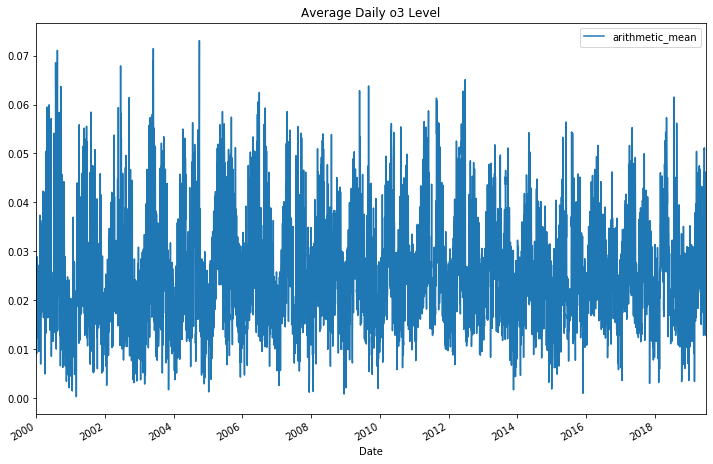

In [107]:
plot_time_series(ts, pollutant)

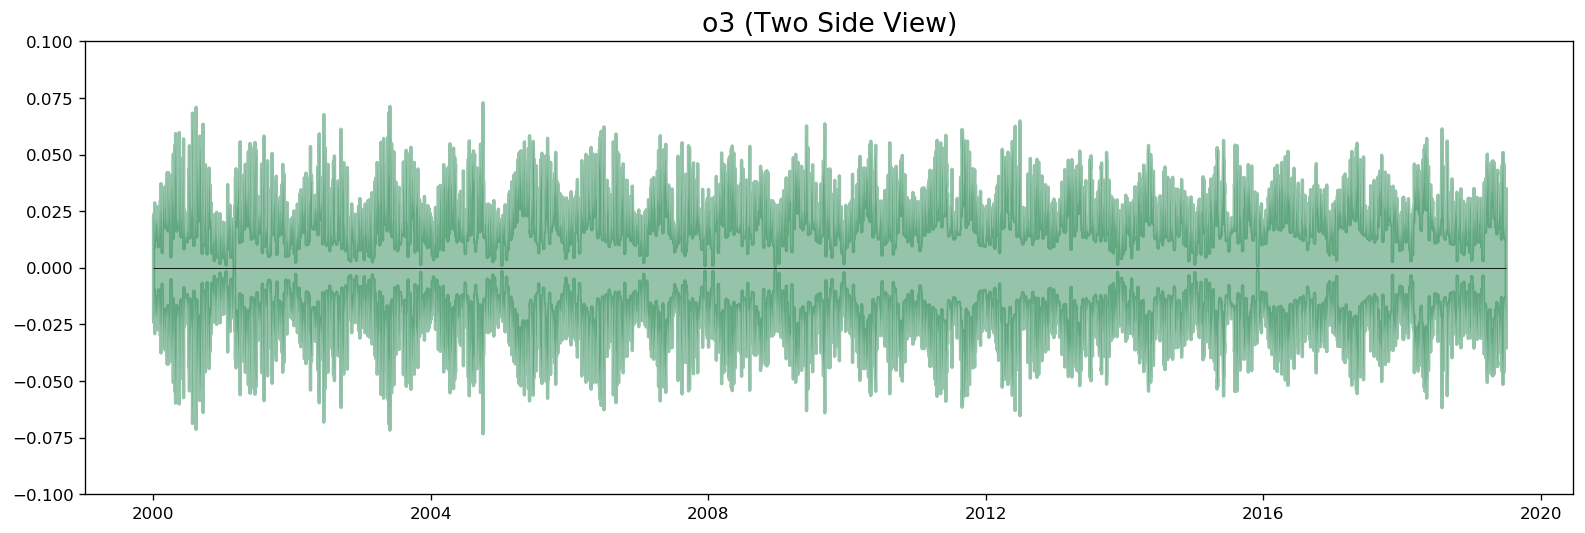

In [108]:
# Plot two sided view mirrored over x axis to see growth
x = ts.index
y1 = ts['arithmetic_mean'].values

fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-.1, .1)
plt.title(f'{pollutant} (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(ts.index), xmax=np.max(ts.index), linewidth=.5)
plt.show()

In [109]:
df.describe()

,county_code,site_num,parameter_code,poc,latitude,longitude,observation_count,observation_percent,arithmetic_mean,1st_max_value,1st_max_hour,aqi,method_code
count,7281203.00,7281203.00,7281203.00,7281203.00,7281203.00,7281203.00,7281203.00,7281203.00,7281203.00,7281203.00,7281203.00,7281197.00,0.00
mean,77.61,1363.40,44201.00,1.30,37.22,-95.33,16.79,98.75,0.03,0.04,10.81,42.86,nan
std,81.21,2689.81,0.00,1.36,4.94,16.38,1.30,7.58,0.01,0.01,3.18,23.16,nan
min,1.00,1.00,44201.00,1.00,18.18,-158.09,1.00,4.00,-0.00,-0.00,7.00,0.00,nan
25%,23.00,6.00,44201.00,1.00,33.75,-111.04,17.00,100.00,0.02,0.03,9.00,30.00,nan
50%,61.00,26.00,44201.00,1.00,37.69,-90.82,17.00,100.00,0.03,0.04,10.00,38.00,nan
75%,103.00,1014.00,44201.00,1.00,40.69,-82.05,17.00,100.00,0.04,0.05,11.00,47.00,nan
max,901.00,9997.00,44201.00,9.00,64.85,-64.80,17.00,100.00,0.19,0.33,23.00,300.00,nan


In [110]:
ts.describe()

,arithmetic_mean
count,7119.00
mean,0.02
std,0.01
min,0.00
25%,0.02
50%,0.02
75%,0.03
max,0.07


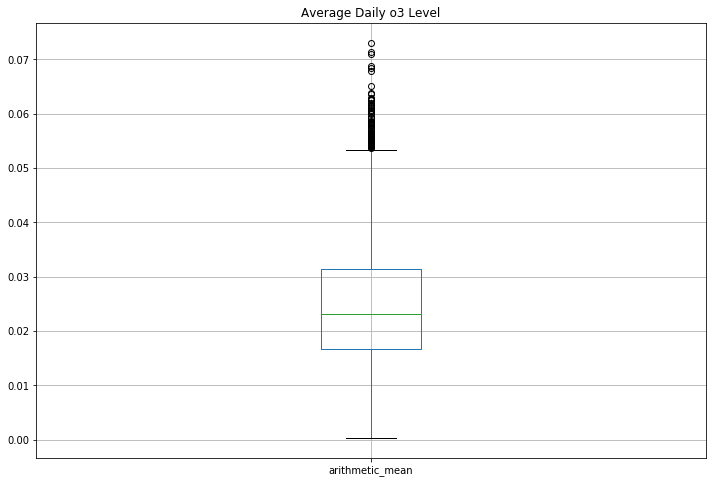

In [111]:
box_plot(ts)

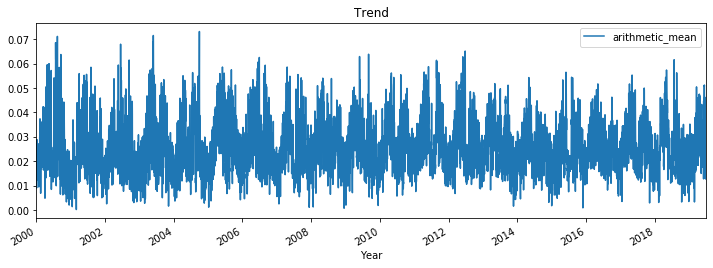

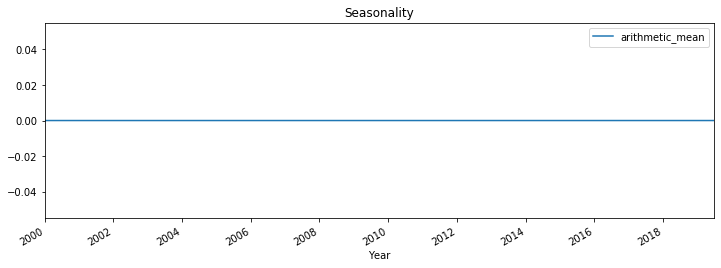

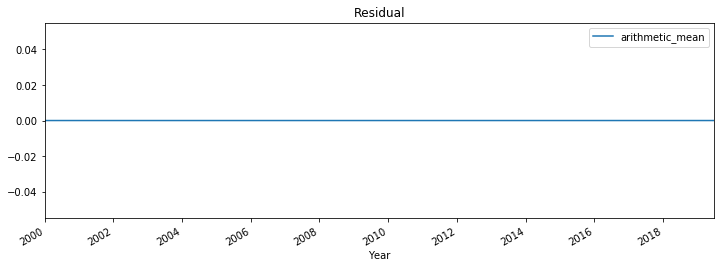

In [112]:
decompose_time_series(ts, freq=1)

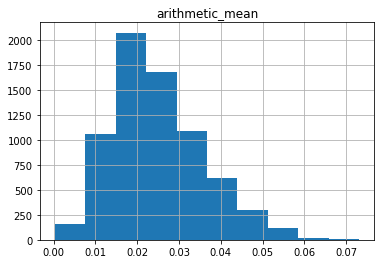

In [137]:
ts.hist();

From the histogram, we see a clear bell curve with a longer tail to the right. 

In [144]:
#Manual stationarity check
X = ts.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.024633, mean2=0.025176
variance1=0.000133, variance2=0.000104


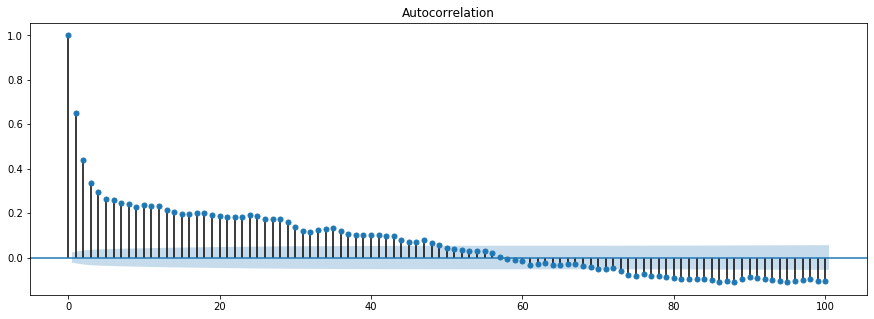

In [118]:
acf_plot(ts)

In the above plot we can see that lags up to 50 have good correlation before the plot first cuts the upper confidence interval. This is our p value i.e the order of our AR process. We can model given AR process using linear combination of first 50 lags.

Order q of the MA process is obtained from the ACF plot, this is the lag after which ACF crosses the upper confidence interval for the first time. In this case, the order is around 3.

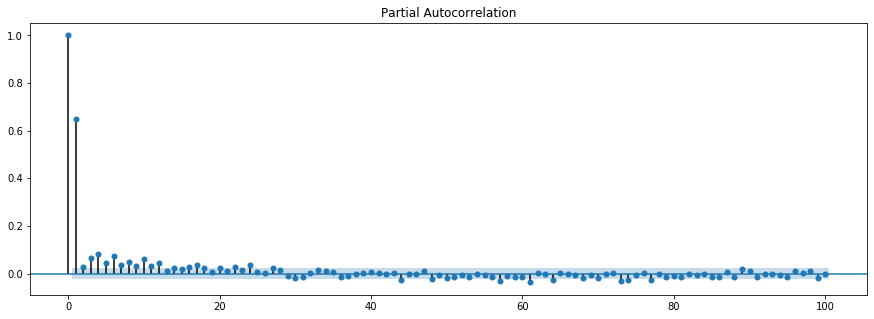

In [119]:
pacf_plot(ts)

In [120]:
len_test = round(.2*len(ts))
train, test = train_test_split(ts, len_test)

Train Test Split Complete 
Length of Train: 5695 	Length of Test: 1424


In [125]:
model = ARIMA(train, order=(1,1,0))

In [126]:
model_fit = model.fit()

In [127]:
yhat = model_fit.forecast()[0]

In [132]:
predictions.append(yhat)

In [129]:
from math import sqrt

In [135]:
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    # fit model
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit()
    # one step forecast
    yhat = model_fit.forecast()[0]
    # store forecast and ob
    predictions.append(yhat)
    history.append(test[t])
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

ValueError: Insufficient degrees of freedom to estimate